Best Sequence: ['P', 'P', 'P', 'P', 'P', 'P', 'P', 'H', 'P', 'P', 'P', 'P', 'P', 'P', 'P', 'P']
Best Energy: -54.0
[['P' 'P' 'P' 'P']
 ['P' 'P' 'P' 'P']
 ['P' 'H' 'P' 'P']
 ['P' 'P' 'P' 'P']]


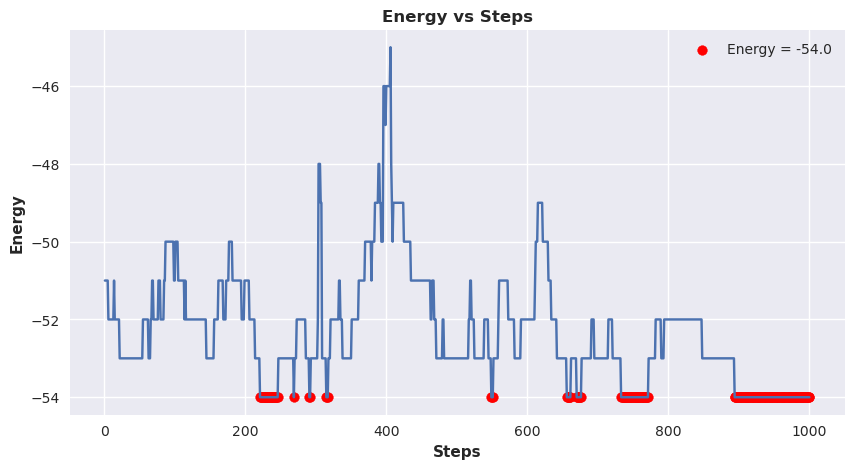

In [24]:
#!/usr/bin/python3
"""
Code to do monte-carlo assignment (11/10/2023). 
Defined a structure of protein as a matrix of residue numbers,
it returns the best sequence of hydrophobic and polar residues.

  How to use-
First you need to have the python package numpy. You can install it with the following command : pip install numpy

You can adjust the temperature and number of steps in the main function.

Then you can run the script with the following command :
    python monte_carlo_assignment.py

  Author
  ------
    Souptik Mandal
"""

import numpy as np
import matplotlib.pyplot as plt
import random

# Constants
INTERACTION_MATRIX = {
    ('P', 'P'): -2,
    ('P', 'H'): 1,
    ('H', 'P'): 1,
    ('H', 'H'): -3
}

SOLVENT_INTERACTIONS_CORNERS = {
    'P': -2,
    'H': 2
}

SOLVENT_INTERACTIONS_SIDES = {
    'P': -1,
    'H': 0
}


def get_matrix_corners_and_sides(matrix):
    '''
    The function returns the corners and exposed sides of the matrix
    Parameters :
        matrix (numpy.ndarray) : The matrix
    Returns :   
        corners (list) : The corners of the matrix
        exposed_sides (list) : The exposed sides of the matrix
    '''
    num_rows = len(matrix)
    num_cols = len(matrix[0])

    if num_rows < 2 or num_cols < 2:
        return [], []

    corners = [matrix[0][0], matrix[0][num_cols - 1], matrix[num_rows - 1][0], matrix[num_rows - 1][num_cols - 1]]

    exposed_sides = []
    for i in range(num_rows):
        for j in range(num_cols):
            if i == 0 and j not in [0, num_cols - 1]:
                exposed_sides.append(matrix[i][j])
            elif i == num_rows - 1 and j not in [0, num_cols - 1]:
                exposed_sides.append(matrix[i][j])
            elif j == 0 and i not in [0, num_rows - 1]:
                exposed_sides.append(matrix[i][j])
            elif j == num_cols - 1 and i not in [0, num_rows - 1]:
                exposed_sides.append(matrix[i][j])

    return corners, exposed_sides

def generate_sequence(num_residue):
    '''
    The function generates a random sequence of hydrophobic and polar residues
    Parameters :
        num_residue (int) : The number of residues in the sequence
    Returns :
        sequence (list) : The sequence of hydrophobic and polar residues
    '''
    return [random.choice(['H', 'P']) for _ in range(num_residue)]


def calculate_energy(sequence, nc_seq_st_pairs, nc_seq_dia_pairs, corners, exposed_sides):
    '''
    The function calculates the energy of the sequence
    Parameters :
        sequence (list) : The sequence of hydrophobic and polar residues
        nc_seq_pairs (list) : The non-covalent sequence interaction pairs
        corners (list) : The corners of the matrix
        exposed_sides (list) : The exposed sides of the matrix
    Returns :
        energy (int) : The energy of the sequence
    '''
    energy = 0
    for pair in nc_seq_st_pairs:
        interaction = INTERACTION_MATRIX.get(pair, 0)
        energy += interaction
    for pair in nc_seq_dia_pairs:
        interaction = INTERACTION_MATRIX.get(pair, 0)
        energy += 0.5*interaction

    # Add solvent interactions based on the sequence
    for i in corners:
        energy += SOLVENT_INTERACTIONS_CORNERS[sequence[i - 1]]
    for i in exposed_sides:
        energy += SOLVENT_INTERACTIONS_SIDES[sequence[i - 1]]

    return energy

def get_neighbours(matrix, sequence):
    '''
    The function Returns the non-covalent sequence interaction pairs
    Parameters :
        matrix (numpy.ndarray) : The matrix
        sequence (list) : The sequence of hydrophobic and polar residues
    Returns :
        nc_seq_pairs (list) : The non-covalent sequence interaction pairs
    '''
    # Initialize the list to store the non-diagonal pairs
    st_pairs = []

    for i in range(4):
        for j in range(4):
            element_1 = matrix[i][j]

            # Define the possible relative positions for element_2
            positions = [(i, j + 1),  (i + 1, j)]    # straight entries

            # Filter out positions that are outside the matrix
            valid_positions = [(x, y) for x, y in positions if 0 <= x < 4 and 0 <= y < 4]

            # Create st_pairs with element_1 and the valid elements
            for x, y in valid_positions:
                element_2 = matrix[x][y]

                if abs(element_1 - element_2) != 1:  # Filtering out the covalent interactions
                    st_pairs.append((element_1, element_2))

    # Use a list comprehension to remove duplicates from the st_pairs list
    unique_st_pairs = list({tuple(sorted(pair)) for pair in st_pairs})

    # Now, you can convert the unique_st_pairs to the corresponding sequence positions
    nc_seq_st_pairs = [(sequence[i - 1], sequence[j - 1]) for i, j in unique_st_pairs]

    # Initialize the list to store the diagonal pairs
    dia_pairs = []

    for i in range(4):
        for j in range(4):
            element_1 = matrix[i][j]

            # Define the possible relative positions for element_2
            positions = [(i + 1, j - 1), (i + 1, j + 1)]    # diagonal entries

            # Filter out positions that are outside the matrix
            valid_positions = [(x, y) for x, y in positions if 0 <= x < 4 and 0 <= y < 4]

            # Create dia_pairs with element_1 and the valid elements
            for x, y in valid_positions:
                element_2 = matrix[x][y]

                # Has no need as there are no covalent interactions in diagonal for the given structure
                if abs(element_1 - element_2) != 1:  # Filtering out the covalent interactions 
                    dia_pairs.append((element_1, element_2))

    # Use a list comprehension to remove duplicates from the dia_pairs list
    unique_dia_pairs = list({tuple(sorted(pair)) for pair in dia_pairs})

    # Now, you can convert the unique_dia_pairs to the corresponding sequence positions
    nc_seq_dia_pairs = [(sequence[i - 1], sequence[j - 1]) for i, j in unique_dia_pairs]
    

    # return nc_seq_st_pairs
    return nc_seq_st_pairs, nc_seq_dia_pairs

def swap_2_residues(sequence):
    '''
    The function mutates the sequence by swapping two residues
    Parameters :
        sequence (list) : The sequence of hydrophobic and polar residues
    Returns :
        mutated_sequence (list) : The mutated sequence of hydrophobic and polar residues
    '''
    # Clone the original sequence
    mutated_sequence = sequence[:]

    # Choose two random positions to swap
    pos1, pos2 = random.sample(range(len(mutated_sequence)), 2)

    # Swap the residues at the selected positions
    mutated_sequence[pos1], mutated_sequence[pos2] = mutated_sequence[pos2], mutated_sequence[pos1]

    return mutated_sequence

def random_point_mutation(sequence):
    '''
    The function mutates the sequence by randomly changing a residue
    Parameters :
        sequence (list) : The sequence of hydrophobic and polar residues
    Returns :
        mutated_sequence (list) : The mutated sequence of hydrophobic and polar residues
    '''
    # Clone the original sequence
    mutated_sequence = sequence[:]

    # Choose a random position
    position = random.randint(0, len(mutated_sequence) - 1)

    # Perform random point mutation (swap 'H' with 'P' or vice versa)
    residue = mutated_sequence[position]
    if residue == 'H':
        mutated_sequence[position] = 'P'
    elif residue == 'P':
        mutated_sequence[position] = 'H'

    return mutated_sequence

def inversion(sequence):
    '''
    This function will invert a random segment within the sequence.
    Parameters :
        sequence (list) : The sequence of hydrophobic and polar residues
    Returns :   
        mutated_sequence (list) : The mutated sequence of hydrophobic and polar residues
    '''
    # Clone the original sequence
    mutated_sequence = sequence[:]

    # Choose two random positions to perform the inversion
    pos1, pos2 = sorted(random.sample(range(len(mutated_sequence)), 2))

    # Perform inversion
    mutated_sequence[pos1:pos2] = sequence[pos1:pos2][::-1]

    return mutated_sequence

def metropolis_criterion(current_energy, proposed_energy, temperature):
    '''
    The function checks if the proposed sequence change is accepted
    Parameters :
        current_energy (int) : The energy of the current sequence
        proposed_energy (int) : The energy of the proposed sequence
        temperature (float) : The temperature of the system
    Returns :
        (bool) : True if the proposed sequence change is accepted, False otherwise
    '''
    if proposed_energy < current_energy:
        return True
    else:
        delta_energy = proposed_energy - current_energy
        probability = np.exp(-delta_energy / temperature)
        return random.random() < probability

def monte_carlo_simulation(matrix, T, num_steps):
    '''
    The function performs Monte Carlo simulation to find the best sequence
    Parameters :
        matrix (numpy.ndarray) : The matrix
        T (float) : The temperature of the system
        num_steps (int) : The number of Monte Carlo steps
    Returns :
        best_sequence (list) : The best sequence of hydrophobic and polar residues
        best_energy (int) : The energy of the best sequence
    '''
    num_residue = matrix.size
    corners, exposed_sides = get_matrix_corners_and_sides(matrix)
    mutation_functions = [swap_2_residues, inversion, random_point_mutation]
    nc_seq_st_pairs, nc_seq_dia_pairs = get_neighbours(matrix, generate_sequence(num_residue))
    best_sequence = generate_sequence(num_residue)
    best_energy = calculate_energy(best_sequence, nc_seq_st_pairs, nc_seq_dia_pairs, corners, exposed_sides)

    current_sequence = best_sequence
    current_energy = best_energy
    energyY = []
    stepX = []
    for step in range(num_steps):
        energyY.append(current_energy)
        stepX.append(step+1)
        temperature = T * (np.cos((9*np.pi/20) * step/num_steps))   # Cooling schedule (cosine annealing)
        mutation_function = random.choice(mutation_functions)
        new_sequence = mutation_function(current_sequence)
        # Update proposed_energy based on the new_sequence
        proposed_energy = calculate_energy(new_sequence, nc_seq_st_pairs, nc_seq_dia_pairs, corners, exposed_sides)

        # Check if we accept the proposed sequence change
        if metropolis_criterion(current_energy, proposed_energy, temperature):
            current_sequence = new_sequence
            current_energy = proposed_energy

            # Update the best sequence and energy if necessary
            if proposed_energy < best_energy:
                best_sequence = current_sequence
                best_energy = proposed_energy

    

    return best_sequence, best_energy, energyY, stepX
    
if __name__ == "__main__":
    '''
    Parameters :
        matrix (numpy.ndarray) : The matrix defining the structure of the protein
        T (float) : The temperature of the system
        num_steps (int) : The number of Monte Carlo steps
    Returns :
        best_sequence (list) : The best sequence of hydrophobic and polar residues
        best_energy (int) : The energy of the best sequence
    Note on temperature (T):
        The temperature used in calculating the metropolis criteria varies over time 
        to allow for more exploration initially and then more exploitation at later stages.
        Cosine annealing is applied in monte_carlo_simulation function, 
        i.e., T is not constant but a function of step
    '''
    matrix = np.array([  
        [1, 2, 15, 16],
        [4, 3, 14, 13],
        [5, 8, 9, 12],
        [6, 7, 10, 11]
    ])

    T = 1 # Adjust the temperature
    num_steps = 1000  # Number of Monte Carlo steps

    best_sequence, best_energy, energyY, stepX = monte_carlo_simulation(matrix, T, num_steps)
    
    print("Best Sequence:", best_sequence)
    print("Best Energy:", best_energy)
    seq_matrix = [['' for _ in range(4)] for _ in range(4)]
    # Fill the seq_matrix with elements from the best_sequence in the desired order
    for i in range(4):
        for j in range(4):
            index = matrix[i][j] - 1  # Adjust index from 1-based to 0-based
            seq_matrix[i][j] = best_sequence[index]
    seq_matrix=np.array(seq_matrix)
    print(seq_matrix)

    # Plotting the energy vs step graph
    plt.figure(figsize=(10, 5))
    plt.style.use('seaborn-v0_8')
    plt.plot(stepX, energyY)
    # Find the indices where the energy is equal to the best energy
    indices = [i for i, energy in enumerate(energyY) if energy == best_energy]
    # Mark the values with a shape or marker at the best energy
    plt.scatter([stepX[i] for i in indices], [best_energy] * len(indices), c='red', marker='o', label=f'Energy = {best_energy}')
    plt.legend()
    plt.xlabel('Steps', fontweight="bold")
    plt.ylabel('Energy', fontweight="bold")
    plt.title('Energy vs Steps', fontweight="bold")
    plt.show()
    